In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.math import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

# <span style="color:purple"> LEITURA DATASET </span>

In [2]:
dataset = pd.read_csv('dataset.csv')
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,classe,signer
0,-0.015155,0.083723,-0.019764,0.016621,0.067022,-0.016464,0.037898,0.040288,-0.018105,0.048381,...,-0.013157,-0.029493,-0.019044,0.004893,-0.044368,-0.022143,0.026663,-0.034211,a,0.0
1,-0.017470,0.089129,-0.024697,0.017672,0.070180,-0.018930,0.037136,0.042391,-0.020137,0.047958,...,-0.013763,-0.033332,-0.020168,0.004791,-0.048958,-0.022997,0.025612,-0.040157,a,0.0
2,-0.018608,0.088464,-0.034686,0.017341,0.069314,-0.027479,0.036115,0.041589,-0.026058,0.046782,...,-0.015631,-0.034420,-0.021920,0.002710,-0.050564,-0.024800,0.022225,-0.041706,a,0.0
3,-0.018881,0.089806,-0.033932,0.017604,0.069527,-0.027086,0.036691,0.042036,-0.025525,0.047545,...,-0.016675,-0.034124,-0.021750,0.000277,-0.050739,-0.023401,0.019764,-0.042837,a,0.0
4,-0.018110,0.088998,-0.032207,0.016747,0.068922,-0.024993,0.036877,0.042021,-0.023326,0.047667,...,-0.015065,-0.034571,-0.020478,0.001885,-0.050963,-0.022766,0.021520,-0.041488,a,0.0


In [3]:
classes = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'i', 'l', 'm', 'n', 'o', 'p',
        'q', 'r', 's', 't', 'u', 'v', 'w', 'y']

In [4]:
le = preprocessing.LabelEncoder()
le.fit(classes)

LabelEncoder()

In [139]:
dataset_train = dataset[dataset['signer'] != 1]

In [140]:
X_train = np.array(dataset_train.iloc[:,:63])
Y_train = np.array(le.transform(dataset_train['classe']))
Y_train = tf.keras.utils.to_categorical(Y_train, len(classes))

X_train = preprocessing.normalize(X_train)

In [141]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [142]:
dataset_test = dataset[dataset['signer'] == 1]

In [143]:
X_test = np.array(dataset_test.iloc[:,:63])
Y_test = np.array(le.transform(dataset_test['classe']))
Y_test = tf.keras.utils.to_categorical(Y_test, len(classes))

X_test = preprocessing.normalize(X_test)

# <span style="color:purple"> ANÁLISE DO DATASET</span>

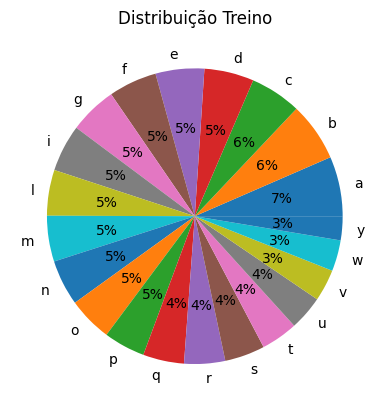

In [144]:
data = dataset_train['classe'].value_counts()
plt.title('Distribuição Treino')
_ = plt.pie(data, labels=classes, autopct='%.0f%%')

ValueError: 'label' must be of length 'x'

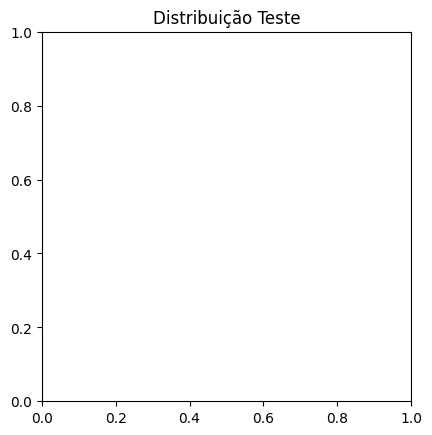

In [138]:
data = dataset_test['classe'].value_counts()
plt.title('Distribuição Teste')
_ = plt.pie(data, labels=classes, autopct='%.0f%%')

# <span style="color:purple"> MODELO </span>

In [120]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv1D(512, kernel_size=12, strides=3, activation='relu', input_shape=(63, 1)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(21, activation='softmax'),
    ]
)

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['categorical_accuracy'])

In [106]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_28 (Conv1D)          (None, 18, 512)           6656      
                                                                 
 dense_88 (Dense)            (None, 18, 256)           131328    
                                                                 
 dense_89 (Dense)            (None, 18, 128)           32896     
                                                                 
 dense_90 (Dense)            (None, 18, 64)            8256      
                                                                 
 dense_91 (Dense)            (None, 18, 32)            2080      
                                                                 
 dropout_19 (Dropout)        (None, 18, 32)            0         
                                                                 
 flatten_19 (Flatten)        (None, 576)             

In [121]:
history = model.fit(X_train, Y_train, batch_size=128, epochs=50, validation_data=(X_val, Y_val))

Epoch 1/50
60/60 [==============================] - 1s 11ms/step - loss: 1.8584 - categorical_accuracy: 0.4018 - val_loss: 0.6246 - val_categorical_accuracy: 0.7979
Epoch 2/50
60/60 [==============================] - 0s 7ms/step - loss: 0.5475 - categorical_accuracy: 0.8086 - val_loss: 0.3078 - val_categorical_accuracy: 0.8924
Epoch 3/50
60/60 [==============================] - 0s 7ms/step - loss: 0.3264 - categorical_accuracy: 0.8858 - val_loss: 0.2010 - val_categorical_accuracy: 0.9270
Epoch 4/50
60/60 [==============================] - 0s 7ms/step - loss: 0.2292 - categorical_accuracy: 0.9160 - val_loss: 0.1419 - val_categorical_accuracy: 0.9580
Epoch 5/50
60/60 [==============================] - 0s 7ms/step - loss: 0.1585 - categorical_accuracy: 0.9443 - val_loss: 0.1193 - val_categorical_accuracy: 0.9648
Epoch 6/50
60/60 [==============================] - 0s 7ms/step - loss: 0.1319 - categorical_accuracy: 0.9534 - val_loss: 0.1043 - val_categorical_accuracy: 0.9601
Epoch 7/50
60/6

In [122]:
model.evaluate(X_test, Y_test)

30/30 [==============================] - 0s 4ms/step - loss: 0.5951 - categorical_accuracy: 0.9255


[0.595129132270813, 0.9255319237709045]

<AxesSubplot:>

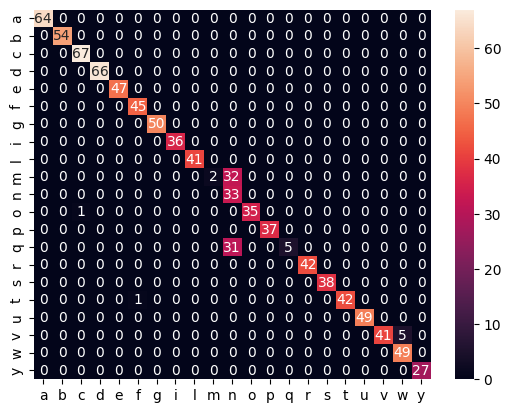

In [123]:
pred = model.predict(X_test)
labels = [np.argmax(y) for y in Y_test]
predictions = [np.argmax(x) for x in pred]
cm = confusion_matrix(labels, predictions)

df_cm = pd.DataFrame(np.array(cm), index = classes, columns = classes)
sns.heatmap(df_cm, annot=True, fmt=".0f")

# <span style="color:purple"> CONCLUSÃO </span>

O modelo confunde as letras:

* F e T
* N e Q
* C e D

Alerta:

* Valor da **loss** muito alta:exclamation:

Próximos passos:

* Obter mais dados